In [857]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Dataset: https://www.kaggle.com/arjunprasadsarkhel/2021-olympics-in-tokyo

### Functions

In [858]:
def annotate(ax, title):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
        ax.set_title(title)

from mpl_toolkits.axes_grid1 import make_axes_locatable
def addColorbar():
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad="0.5%")
    return ax, cax

### Read teams dataset

In [859]:
df_teams = pd.read_excel("data/Teams.xlsx")
print(df_teams.head(),"\n")
print(df_teams.info(),"\n")
print(f"Countries: {len(df_teams['NOC'].unique().tolist())}, Disciplines: {len(df_teams['Discipline'].unique().tolist())}, Events: {len(df_teams['Event'].unique().tolist())}")

      Name      Discipline                         NOC  Event
0  Belgium  3x3 Basketball                     Belgium    Men
1    China  3x3 Basketball  People's Republic of China    Men
2    China  3x3 Basketball  People's Republic of China  Women
3   France  3x3 Basketball                      France  Women
4    Italy  3x3 Basketball                       Italy  Women 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        743 non-null    object
 1   Discipline  743 non-null    object
 2   NOC         743 non-null    object
 3   Event       743 non-null    object
dtypes: object(4)
memory usage: 23.3+ KB
None 

Countries: 84, Disciplines: 20, Events: 36


- No missing values
- Countries 84 Discipline 20

#### How many disciplines each country participated in?

<AxesSubplot:xlabel='NOC'>

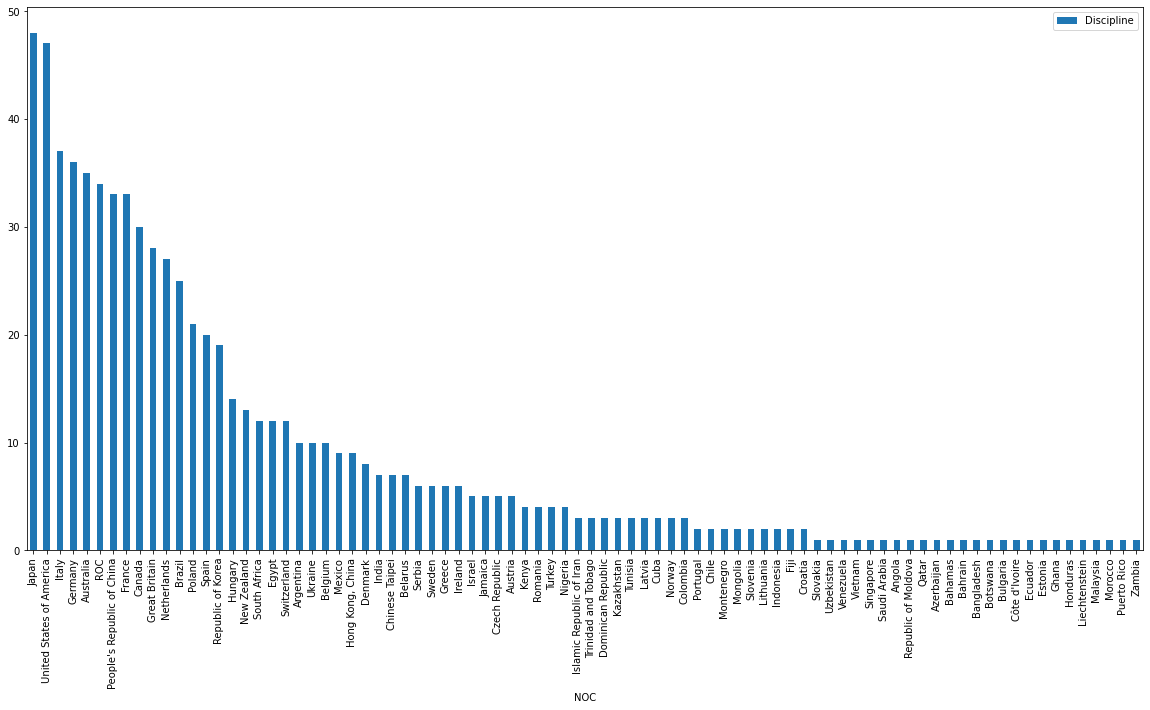

In [860]:
df_teams_ = df_teams.groupby(by="NOC").agg({'Discipline':'count'})
df_teams_.reset_index(inplace=True)
teams_sorted = df_teams_.sort_values(by='Discipline', ascending=False)
teams_sorted.plot.bar(x='NOC', figsize=(20,10))

#### How many countries each Discipline had participants from? Which countries participated in the least participated disciplines?

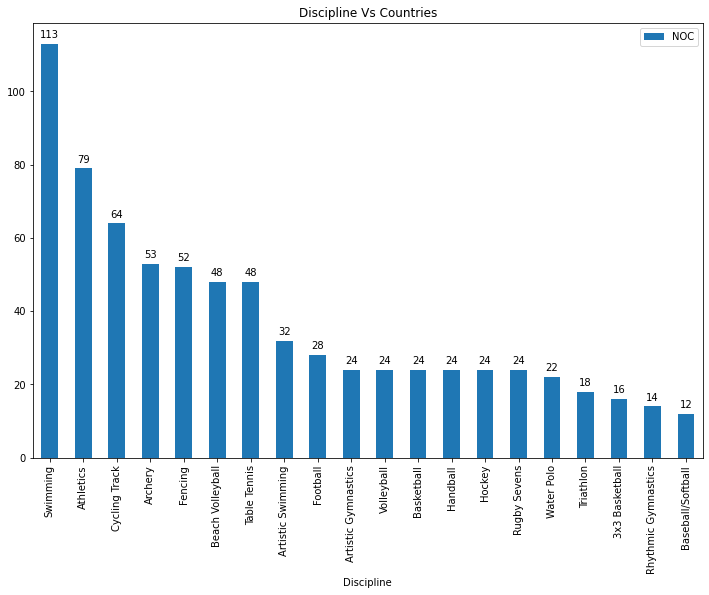

In [861]:
df_discipline_countries = df_teams.groupby(by='Discipline').agg({'NOC':'count'}).sort_values(by='NOC', ascending=False)
ax = df_discipline_countries.plot.bar(figsize=(12, 8))
annotate(ax, "Discipline Vs Countries")

In [862]:
least_participated_disciplines = df_discipline_countries[df_discipline_countries['NOC']<13].index.tolist()
print(least_participated_disciplines)
df_teams_least_disciplines = df_teams[df_teams['Discipline'].isin(least_participated_disciplines)].groupby(by=['NOC','Discipline']).agg({'Discipline':'count'})
df_teams_least_disciplines.groupby(by=['NOC']).agg({'Discipline':'count'}).sort_values(by='Discipline', ascending=False)

['Baseball/Softball']


Discipline
NOC                                 
Australia                          1
Canada                             1
Dominican Republic                 1
Israel                             1
Italy                              1
Japan                              1
Mexico                             1
Republic of Korea                  1
United States of America           1

### Read world geo dataset

In [863]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(df_world.head())
print(f"{type(df_world)}, {df_world.geometry.name}")
print(df_world.geometry.geom_type.value_counts())

     pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
<class 'geopandas.geodataframe.GeoDataFrame'>, geometry
Polygon         148
MultiPolygon     29
dtype: int64


<AxesSubplot:>

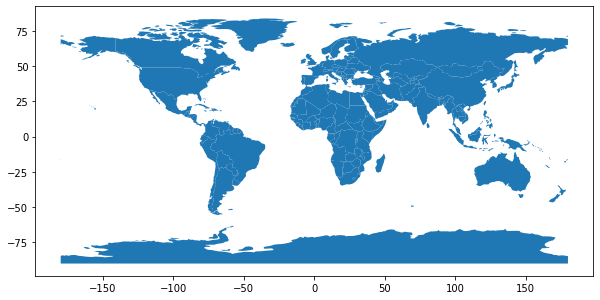

In [864]:
df_world.plot(figsize=(10,6))

### Fix the discrepancies in the country names

In [865]:
geopandas_countries = set(df_world['name'].unique().tolist())
teams_countries = set(df_teams['NOC'].unique().tolist())
print("geopandas_countries", len(geopandas_countries), "teams_countries", len(teams_countries))
print("Countries in teams but not found in the geo dataset")
diff_country_names = list(teams_countries-geopandas_countries); diff_country_names
diff_country_names

geopandas_countries 177 teams_countries 84
Countries in teams but not found in the geo dataset


['Republic of Korea',
 "People's Republic of China",
 'Dominican Republic',
 'Singapore',
 'Liechtenstein',
 'Bahrain',
 'ROC',
 'Islamic Republic of Iran',
 'Great Britain',
 'Republic of Moldova',
 'Chinese Taipei',
 'Hong Kong, China',
 'Czech Republic']

In [866]:
subs = ["Bah", "Taipei", "Czech", "Domi", "Great", "Britain", "Hong", "Iran", "China", "Liech", "Korea", "ROD", "Mol", "Sing"]
for country in geopandas_countries:
    for sub in subs:
        if sub in country:
            print(sub, "- ", country)

China -  China
Korea -  South Korea
Korea -  North Korea
Czech -  Czechia
Iran -  Iran
Mol -  Moldova
Bah -  Bahamas
Domi -  Dominican Rep.


In [867]:
team_to_geopandas_countries = { "People's Republic of China" : "China",
                                'Republic of Korea': 'South Korea',
                                'Republic of Moldova':'Moldova',
                                'Czech Republic':'Czechia',
                                'Islamic Republic of Iran':'Iran',
                                'Dominican Republic':'Dominican Rep.',
                                'ROC' : 'Russia',
                                'Great Britain': 'United Kingdom'}

# Countries that are not present in the geopandas. So ignore these
'''
    'Great Britain',
    'Singapore',
    'Bahrain',
    'Liechtenstein',
    'Hong Kong, China',
    'Chinese Taipei'
'''

"\n    'Great Britain',\n    'Singapore',\n    'Bahrain',\n    'Liechtenstein',\n    'Hong Kong, China',\n    'Chinese Taipei'\n"

In [868]:
print(df_world[df_world['name'].str[0]=='B']['name'])
print(df_world[df_world['name'].str[0]=='H']['name'])
print(df_world[df_world['name'].str[0]=='L']['name'])
print(df_world[df_world['name'].str[0]=='R']['name'])
print(df_world[df_world['name'].str[:2]=='Si']['name'])
print(df_world[df_world['name'].str[0]=='U']['name'])

19              Bahamas
29               Brazil
30              Bolivia
39               Belize
49             Botswana
54                Benin
65         Burkina Faso
75              Burundi
99           Bangladesh
100              Bhutan
111             Belarus
122            Bulgaria
129             Belgium
149              Brunei
170    Bosnia and Herz.
Name: name, dtype: object
16        Haiti
36     Honduras
115     Hungary
Name: name, dtype: object
26        Lesotho
63        Liberia
77        Lebanon
92           Laos
118     Lithuania
119        Latvia
128    Luxembourg
164         Libya
Name: name, dtype: object
18      Russia
117    Romania
169     Rwanda
Name: name, dtype: object
64    Sierra Leone
Name: name, dtype: object
4      United States of America
6                    Uzbekistan
28                      Uruguay
84         United Arab Emirates
112                     Ukraine
143              United Kingdom
168                      Uganda
Name: name, dtype: object


In [869]:
for country in team_to_geopandas_countries.keys():
    print(df_teams[df_teams['NOC'] == country]['NOC'].tolist()[0])

People's Republic of China
Republic of Korea
Republic of Moldova
Czech Republic
Islamic Republic of Iran
Dominican Republic
ROC
Great Britain


In [870]:
print("Before", list(set(df_teams['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.values())), list(set(df_teams['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.keys())))
for country in team_to_geopandas_countries.keys():
    df_teams.loc[df_teams['NOC'] == country, 'NOC'] = team_to_geopandas_countries[country]
print("After", list(set(df_teams['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.values())), list(set(df_teams['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.keys())))

Before [] ['Republic of Korea', "People's Republic of China", 'Dominican Republic', 'ROC', 'Islamic Republic of Iran', 'Republic of Moldova', 'Great Britain', 'Czech Republic']
After ['Iran', 'Dominican Rep.', 'Czechia', 'United Kingdom', 'China', 'Moldova', 'Russia', 'South Korea'] []


In [871]:
'''df_teams_least_disciplines.rename(columns={'Discipline':'Count'}, inplace=True)
df_teams_least_disciplines = df_teams_least_disciplines.reset_index()
df_teams_least_disciplines'''

NOC         Discipline  Count
0                 Australia  Baseball/Softball      1
1                    Canada  Baseball/Softball      1
2        Dominican Republic  Baseball/Softball      1
3                    Israel  Baseball/Softball      1
4                     Italy  Baseball/Softball      1
5                     Japan  Baseball/Softball      2
6                    Mexico  Baseball/Softball      2
7         Republic of Korea  Baseball/Softball      1
8  United States of America  Baseball/Softball      2

In [872]:
'''countries = df_teams_least_disciplines['NOC'].tolist()
print("Before", list(set(df_teams_least_disciplines['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.values())), list(set(df_teams_least_disciplines['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.keys())))
for country in countries:
    print(df_teams_least_disciplines[df_teams_least_disciplines['NOC'] == country]['NOC'].tolist()[0])
    if country in team_to_geopandas_countries.keys():
        df_teams_least_disciplines.loc[df_teams_least_disciplines['NOC'] == country, 'NOC'] = team_to_geopandas_countries[country]
print("After", list(set(df_teams_least_disciplines['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.values())), list(set(df_teams_least_disciplines['NOC'].unique().tolist()).intersection(team_to_geopandas_countries.keys())))'''

Before [] ['Dominican Republic', 'Republic of Korea']
Australia
Canada
Dominican Republic
Israel
Italy
Japan
Mexico
Republic of Korea
United States of America
After ['Dominican Rep.', 'South Korea'] []


### Merge teams and world datasets to create  a new dataset

In [873]:
df_world_teams = df_world.merge(df_teams_, how="left", left_on=['name'], right_on=['NOC'])
print("Type of DataFrame : ", type(df_world_teams), df_world_teams.shape[0])
df_world_teams.head()

Type of DataFrame :  <class 'geopandas.geodataframe.GeoDataFrame'> 177


pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

                        NOC  Discipline  
0                      Fiji         2.0  
1                       NaN         NaN  
2                       NaN         NaN  
3                    Canada        30.0  
4  United States of America        47.0

In [874]:
print(len(df_world_teams['NOC'].unique()))
df_world_teams['NOC'].unique()

72


array(['Fiji', nan, 'Canada', 'United States of America', 'Kazakhstan',
       'Uzbekistan', 'Indonesia', 'Argentina', 'Chile', 'Kenya',
       'Bahamas', 'Norway', 'South Africa', 'Mexico', 'Brazil',
       'Colombia', 'Honduras', 'Venezuela', 'France', 'Ecuador',
       'Puerto Rico', 'Jamaica', 'Cuba', 'Botswana', 'Nigeria', 'Ghana',
       "Côte d'Ivoire", 'Zambia', 'Angola', 'Israel', 'Tunisia', 'Qatar',
       'Vietnam', 'Mongolia', 'India', 'Bangladesh', 'Sweden', 'Belarus',
       'Ukraine', 'Poland', 'Austria', 'Hungary', 'Romania', 'Lithuania',
       'Latvia', 'Estonia', 'Germany', 'Bulgaria', 'Greece', 'Turkey',
       'Croatia', 'Switzerland', 'Belgium', 'Netherlands', 'Portugal',
       'Spain', 'Ireland', 'New Zealand', 'Australia', 'Italy', 'Denmark',
       'Azerbaijan', 'Malaysia', 'Slovenia', 'Slovakia', 'Japan',
       'Saudi Arabia', 'Morocco', 'Egypt', 'Serbia', 'Montenegro',
       'Trinidad and Tobago'], dtype=object)

### 1. Add map with only borders

<AxesSubplot:>

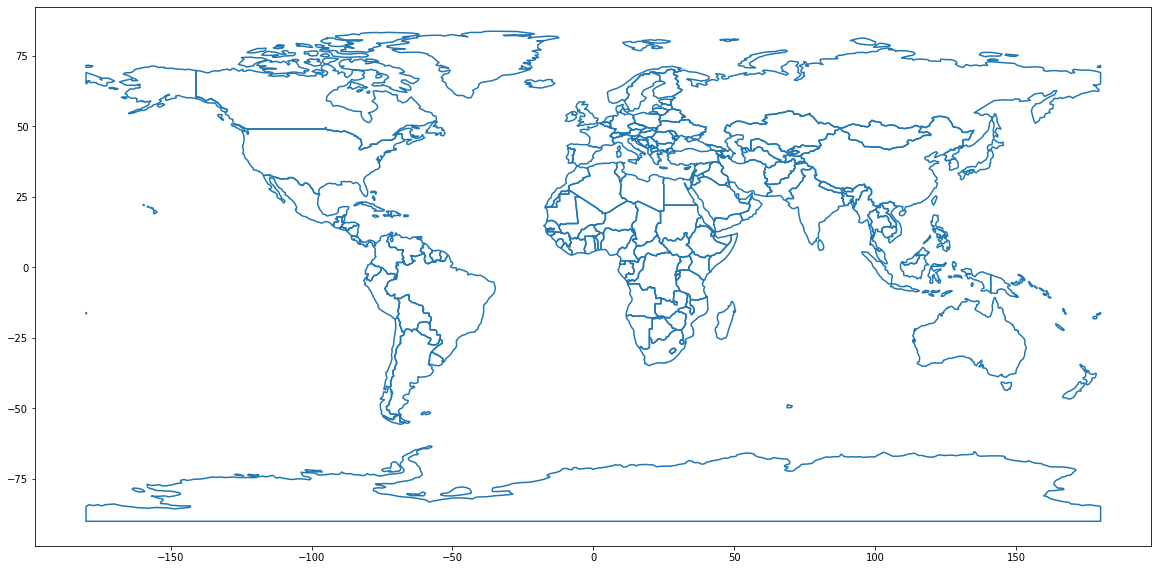

In [875]:
df_world["geometry"].boundary.plot(figsize=(20,16))

### 2. Color the countries based on the number of disciplines they participated in

Text(0.5, 1.0, 'Countries Vs Number of Disciplines Particpated in 2021 Olympics')

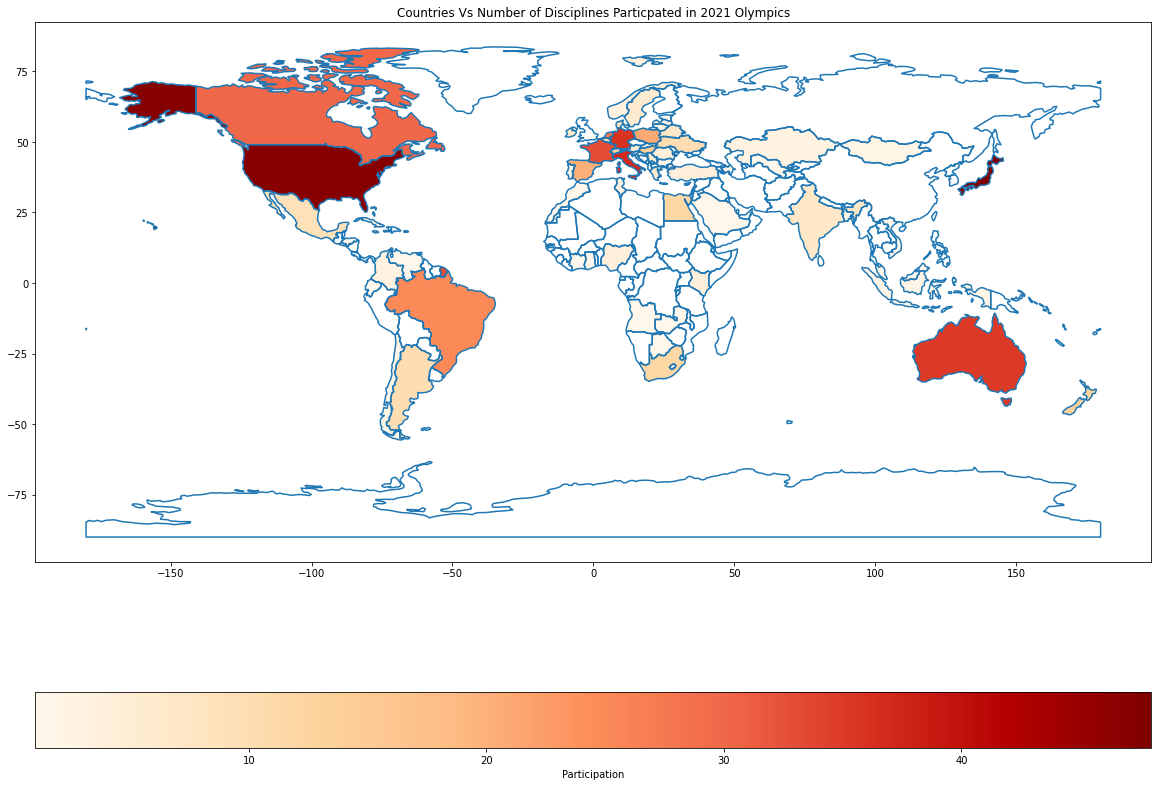

In [876]:
ax = df_world["geometry"].boundary.plot(figsize=(20,16))
df_world_teams.plot( "Discipline", ax=ax, cmap='OrRd', 
                     legend=True, legend_kwds={"label": "Participation", "orientation":"horizontal"})
ax.set_title("Countries Vs Number of Disciplines Particpated in 2021 Olympics")

### 3. Make the colorbar look better

Text(0.5, 1.0, 'Countries Vs Number of Disciplines Particpated in 2021 Olympics')

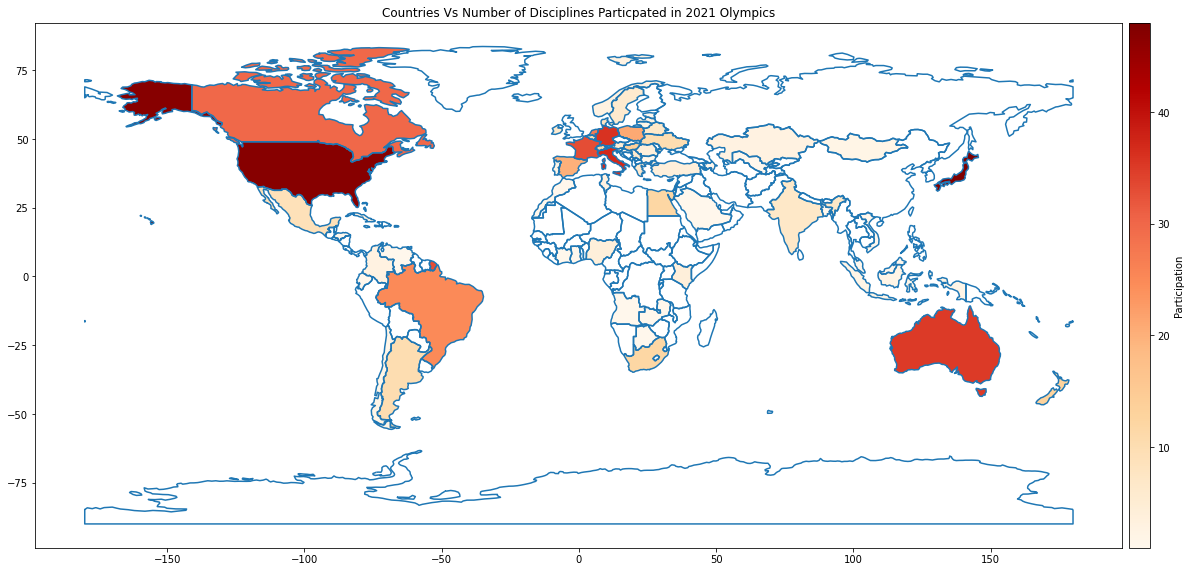

In [877]:
ax, cax = addColorbar()
df_world["geometry"].boundary.plot(ax=ax, figsize=(20,16))
df_world_teams.plot("Discipline", ax=ax, cax=cax, cmap='OrRd', 
                    legend=True, legend_kwds={"label": "Participation"})
ax.set_title("Countries Vs Number of Disciplines Particpated in 2021 Olympics")

Americas, & Australia is majorly participated

### 4. Mark the countries that didn't participate in grey

Text(0.5, 1.0, 'Countries Vs Number of Disciplines Particpated in 2021 Olympics')

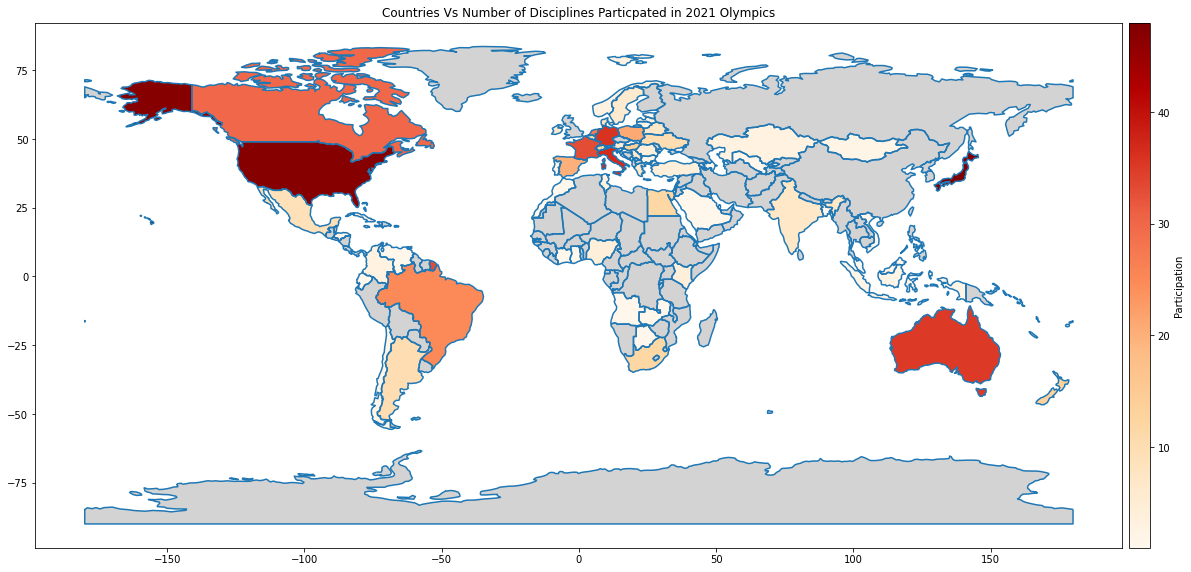

In [878]:
ax, cax = addColorbar()
df_world["geometry"].boundary.plot(ax=ax,figsize=(20,16))
df_world_teams.plot("Discipline", ax=ax,  cax=cax, cmap='OrRd', 
                    legend=True, legend_kwds={"label": "Participation"},  missing_kwds={'color': 'lightgrey'})
ax.set_title("Countries Vs Number of Disciplines Particpated in 2021 Olympics")

Text(0.5, 1.0, 'Countries Vs Number of Disciplines Particpated in 2021 Olympics')

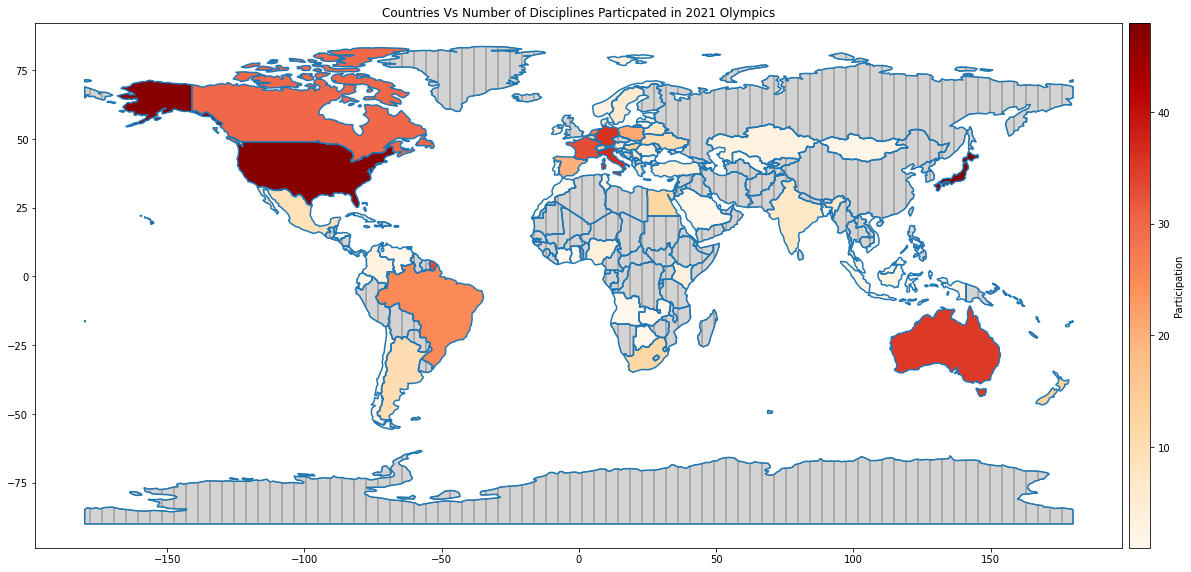

In [879]:
ax, cax = addColorbar()
df_world["geometry"].boundary.plot(ax=ax, figsize=(20,16))
df_world_teams.plot(column= 'Discipline', ax=ax,  cax=cax, cmap='OrRd', 
                    legend=True, legend_kwds={"label": "Participation"}, 
                    missing_kwds={"color": "lightgrey", "edgecolor": "grey", "hatch": "|", "label": "Missing values",},)
ax.set_title("Countries Vs Number of Disciplines Particpated in 2021 Olympics")

### 5. Mark the countries participated in least participated disciplines

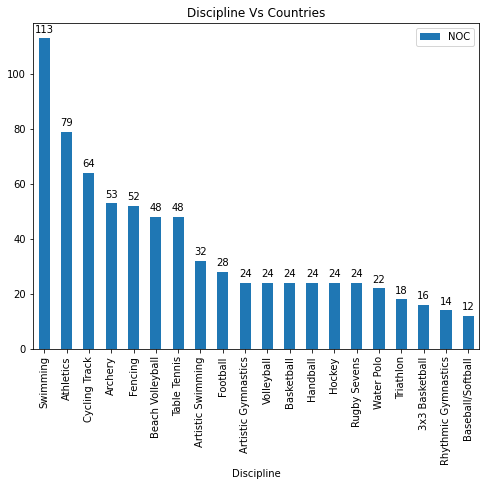

In [904]:
df_discipline_countries = df_teams.groupby(by='Discipline').agg({'NOC':'count'}).sort_values(by='NOC', ascending=False)
ax = df_discipline_countries.plot.bar(figsize=(8, 6))
annotate(ax, "Discipline Vs Countries")

In [910]:
least_participated_disciplines = df_discipline_countries[df_discipline_countries['NOC']<1].index.tolist()
print(least_participated_disciplines)
df_teams_least_disciplines = df_teams[df_teams['Discipline'].isin(least_participated_disciplines)].groupby(by=['NOC','Discipline']).agg({'Discipline':'count'})
df_teams_least_disciplines.groupby(by=['NOC']).agg({'Discipline':'count'}).sort_values(by='Discipline', ascending=False)

['Rhythmic Gymnastics', 'Baseball/Softball']


Discipline
NOC                                 
Australia                          2
Italy                              2
United States of America           2
Japan                              2
Israel                             2
Canada                             1
China                              1
Dominican Rep.                     1
Egypt                              1
Azerbaijan                         1
Bulgaria                           1
Brazil                             1
Mexico                             1
Russia                             1
South Korea                        1
Ukraine                            1
Belarus                            1
Uzbekistan                         1

In [911]:
df_world_teams_least_disciplines = df_world.merge(df_teams_least_disciplines, how="right", left_on=['name'], right_on=['NOC'])
df_world_teams_least_disciplines['centroid'] = df_world_teams_least_disciplines.centroid
print("Type of DataFrame : ", type(df_world_teams_least_disciplines),df_world_teams_least_disciplines.shape[0])
print(df_world_teams_least_disciplines[:10])

Type of DataFrame :  <class 'geopandas.geodataframe.GeoDataFrame'> 23
      pop_est      continent            name iso_a3  gdp_md_est  \
0    23232413        Oceania       Australia    AUS   1189000.0   
1    23232413        Oceania       Australia    AUS   1189000.0   
2     9961396           Asia      Azerbaijan    AZE    167900.0   
3     9549747         Europe         Belarus    BLR    165400.0   
4   207353391  South America          Brazil    BRA   3081000.0   
5     7101510         Europe        Bulgaria    BGR    143100.0   
6    35623680  North America          Canada    CAN   1674000.0   
7  1379302771           Asia           China    CHN  21140000.0   
8    10734247  North America  Dominican Rep.    DOM    161900.0   
9    97041072         Africa           Egypt    EGY   1105000.0   

                                            geometry  Discipline  \
0  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...           1   
1  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...    

/var/folders/6d/t1t1r89n1q95d2ztv2qstyb40000gr/T/ipykernel_86255/875244864.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_world_teams_least_disciplines['centroid'] = df_world_teams_least_disciplines.centroid


Text(0.5, 1.0, 'Countries Vs Number of Disciplines Particpated in 2021 Olympics')

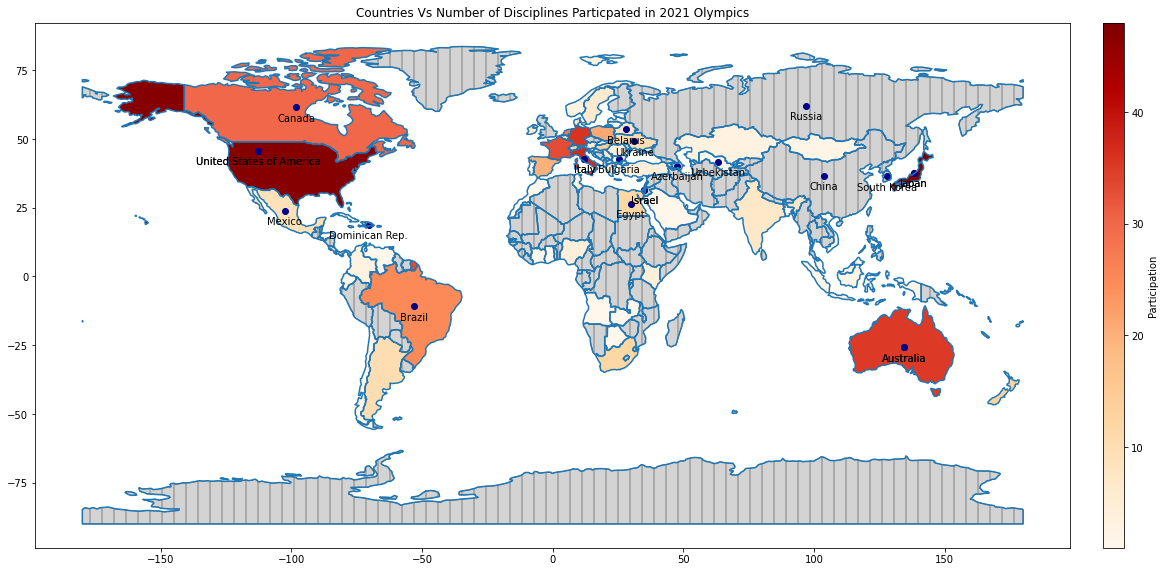

In [912]:
ax, cax = addColorbar()
df_world["geometry"].boundary.plot(ax=ax, figsize=(20,16))
df_world_teams.plot(column= 'Discipline', ax=ax, cax=cax, cmap='OrRd',
                    legend=True, legend_kwds={"label": "Participation"}, 
                    missing_kwds={"color": "lightgrey", "edgecolor": "grey", "hatch": "|", "label": "Missing values",})
df_world_teams_least_disciplines["centroid"].plot(ax=ax, color="DarkBlue")

df_world_teams_least_disciplines.apply(lambda x: ax.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]-5), ha='center'), axis=1)
ax.set_title("Countries Vs Number of Disciplines Particpated in 2021 Olympics")